# IMDB project: predicting movies scores
### by Javier Alonso

This Jupyter Notebook is part of ["My IMDB project"](https://javieralonsoalonso.com/category/my-imdb-project/) and classify movies correctly in different labels depending on the average score. In this second test, we try this withe the 5% most voted movies to see if it gets better results than just getting movies with votes.

The database was downloaded from IMDB on 2020/05/25 but some days after, they changed all the system for retrieving the data, so we won´t be able to upgrade easily the project with new data.

The results have been posted in my ["My blog"](https://javieralonsoalonso.com/category/my-imdb-project/)

## Table of Contents

1. [Preliminary Wrangling](#Preliminary_Wrangling)<br>
1.a.-[Gathering Data](#Gathering_Data)<br>
1.b.-[Assesing and Cleaning Data](#Assesing_cleaning_data)<br>
1.c.-[Consolidation of Dataframes](#Consolidaion_dataframes)<br>
2. [Machine Learning Algorithm](#MLA)<br>
3.a.-[Data preparation](#Data_preparation)<br>
3.b.-[Algorithm Selection](#Alg_Selection)<br>

## <a class="anchor" id="Preliminary_Wrangling">Part 1: Preliminary Wrangling

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import time

%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler


from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.metrics import f1_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import uniform as sp_rand
from scipy.stats import uniform as sp_randFloat
from scipy.stats import uniform as sp_randInt
from scipy.stats import uniform as sp_random

### <a class="anchor" id="Gathering_Data"> 1.a.- Gathering Data

In this section we´ll gather data from the precleaned dataset for the EDA

In [2]:
df_movies = pd.read_csv('IMDB_clean_movies.csv')
df_movies.shape

(221748, 12)

A view of the dataframe

In [3]:
df_movies.head(5)

,idMovie,originalTitle,Year,Minutes,Genres,averageRating,numVotes,decade,director,actors,actress,writers
0,tt0000009,Miss Jerry,1894,45,Romance,5.9,153,1890,Alexander Black,"William Courtenay,Chauncey Depew",Blanche Bayliss,Not available
1,tt0000147,The Corbett-Fitzsimmons Fight,1897,20,"Documentary,News,Sport",5.2,346,1890,Enoch J. Rector,Not available,Not available,Not available
2,tt0000335,Soldiers of the Cross,1900,91,"Biography,Drama",6.1,40,1900,"Herbert Booth,Joseph Perry","Harold Graham,Mr. Graham,John Jones,Orrie Perr...",Beatrice Day,Not available
3,tt0000502,Bohemios,1905,100,No available,3.8,6,1900,Ricardo de Baños,"Antonio del Pozo,El Mochuelo",Not available,"Marguerite Thévenard,Bleuette Bernon"
4,tt0000574,The Story of the Kelly Gang,1906,70,"Biography,Crime,Drama",6.1,574,1900,Charles Tait,"John Tait,Norman Campbell","Elizabeth Tait,Bella Cola",Not available


### <a class="anchor" id="Assesing_cleaning_data"> 1.b.- Asessing and cleaning data

Now, we´re going to assess the dataframe visually and programmatically for quality and tidiness issues, and do the cleaning of these issues

First thing we do a copy of my dataframe


In [22]:
movies = df_movies.copy()

In [23]:
movies.head()

,idMovie,originalTitle,Year,Minutes,Genres,averageRating,numVotes,decade,director,actors,actress,writers
0,tt0000009,Miss Jerry,1894,45,Romance,5.9,153,1890,Alexander Black,"William Courtenay,Chauncey Depew",Blanche Bayliss,Not available
1,tt0000147,The Corbett-Fitzsimmons Fight,1897,20,"Documentary,News,Sport",5.2,346,1890,Enoch J. Rector,Not available,Not available,Not available
2,tt0000335,Soldiers of the Cross,1900,91,"Biography,Drama",6.1,40,1900,"Herbert Booth,Joseph Perry","Harold Graham,Mr. Graham,John Jones,Orrie Perr...",Beatrice Day,Not available
3,tt0000502,Bohemios,1905,100,No available,3.8,6,1900,Ricardo de Baños,"Antonio del Pozo,El Mochuelo",Not available,"Marguerite Thévenard,Bleuette Bernon"
4,tt0000574,The Story of the Kelly Gang,1906,70,"Biography,Crime,Drama",6.1,574,1900,Charles Tait,"John Tait,Norman Campbell","Elizabeth Tait,Bella Cola",Not available


#### Keeping top voted movies

For the prediction we will keep only the 5% top voted movies. Let´s see if these can be predicted better than in the first case of the project

In [24]:
movies['numVotes'].describe(percentiles=[0.5,0.9,0.95])

count    2.217480e+05
mean     3.667128e+03
std      3.315393e+04
min      5.000000e+00
50%      5.600000e+01
90%      1.791000e+03
95%      6.293000e+03
max      2.242140e+06
Name: numVotes, dtype: float64

In [25]:
len(movies)

221748

In [26]:
movies = movies[movies.numVotes>6293]

In [27]:
len(movies)

11086

So we will try to predict the label rates in 11.086 movies that are the top 5% most voted movies.

#### Incorrect datatypes

Decade should be string. We change the datatype

In [28]:
movies.decade = movies.decade.astype(str)

In [29]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11086 entries, 263 to 221712
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   idMovie        11086 non-null  object 
 1   originalTitle  11086 non-null  object 
 2   Year           11086 non-null  int64  
 3   Minutes        11086 non-null  int64  
 4   Genres         11086 non-null  object 
 5   averageRating  11086 non-null  float64
 6   numVotes       11086 non-null  int64  
 7   decade         11086 non-null  object 
 8   director       11086 non-null  object 
 9   actors         11086 non-null  object 
 10  actress        11085 non-null  object 
 11  writers        11086 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 1.1+ MB


#### Deleting columns

**Director, actors, actress and writers column** as we will get them from other dataframe

In [30]:
movies = movies.drop(['director'], axis=1)
movies = movies.drop(['actors'], axis=1)
movies = movies.drop(['actress'], axis=1)
movies = movies.drop(['writers'], axis=1)

In [31]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11086 entries, 263 to 221712
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   idMovie        11086 non-null  object 
 1   originalTitle  11086 non-null  object 
 2   Year           11086 non-null  int64  
 3   Minutes        11086 non-null  int64  
 4   Genres         11086 non-null  object 
 5   averageRating  11086 non-null  float64
 6   numVotes       11086 non-null  int64  
 7   decade         11086 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 779.5+ KB


**Getting the crew info**

In [32]:
crew = pd.read_csv('IMDB_clean_crew.csv')

**Merging the information**

In [33]:
movies = pd.merge(movies, crew, left_on = 'idMovie', right_on = 'tconst', how = 'left')

In [34]:
movies.columns

Index(['idMovie', 'originalTitle', 'Year', 'Minutes', 'Genres',
       'averageRating', 'numVotes', 'decade', 'tconst', 'actor', 'actress',
       'director', 'writer'],
      dtype='object')

In [35]:
len(movies)

11086

In [36]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11086 entries, 0 to 11085
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   idMovie        11086 non-null  object 
 1   originalTitle  11086 non-null  object 
 2   Year           11086 non-null  int64  
 3   Minutes        11086 non-null  int64  
 4   Genres         11086 non-null  object 
 5   averageRating  11086 non-null  float64
 6   numVotes       11086 non-null  int64  
 7   decade         11086 non-null  object 
 8   tconst         11066 non-null  object 
 9   actor          11066 non-null  object 
 10  actress        11066 non-null  object 
 11  director       11066 non-null  object 
 12  writer         11066 non-null  object 
dtypes: float64(1), int64(3), object(9)
memory usage: 1.2+ MB


In [37]:
#We delete the nans
movies = movies.dropna()

**Keeping only the important crew**

In [38]:
movies.head()

,idMovie,originalTitle,Year,Minutes,Genres,averageRating,numVotes,decade,tconst,actor,actress,director,writer
0,tt0004972,The Birth of a Nation,1915,195,"Drama,History,War",6.3,21678,1910,tt0004972,Henry B. Walthall,Lillian Gish,D.W. Griffith,Thomas Dixon Jr.
1,tt0006864,Intolerance: Love's Struggle Throughout the Ages,1916,163,"Drama,History",7.8,13621,1910,tt0006864,Robert Harron,Lillian Gish,D.W. Griffith,Hettie Grey Baker
2,tt0009968,Broken Blossoms or The Yellow Man and the Girl,1919,90,"Drama,Romance",7.3,9114,1910,tt0009968,Richard Barthelmess,Lillian Gish,D.W. Griffith,Thomas Burke
3,tt0010323,Das Cabinet des Dr. Caligari,1920,76,"Fantasy,Horror,Mystery",8.1,54469,1920,tt0010323,Werner Krauss,Lil Dagover,Robert Wiene,Carl Mayer
4,tt0011237,"Der Golem, wie er in die Welt kam",1920,76,"Fantasy,Horror",7.2,6344,1920,tt0011237,Paul Wegener,Lyda Salmonova,Carl Boese,Henrik Galeen


In [39]:
n_actors = len(movies.actor.unique())
n_actress = len(movies.actress.unique())
n_director = len(movies.director.unique())
n_writer = len(movies.writer.unique())

In [40]:
print("There are", n_actors, "different actors,", n_actress,"different actresses,", n_director," different directors and", n_writer,"different writers")

There are 3813 different actors, 3960 different actresses, 4232  different directors and 5770 different writers


With these numbers is impossible to create different dummies for each of them so we are going to delimit them to 500 for each category, that will be the ones that are present in more movies

In [41]:
n = 500
top_actors = movies[movies.actor != 'Not available'].groupby("actor")['idMovie'].count()
top_actors = top_actors.to_frame().reset_index().sort_values(by = 'idMovie', ascending = False)['actor'].head(n).to_list()
top_actress = movies[movies.actress != 'Not available'].groupby("actress")['idMovie'].count()
top_actress = top_actress.to_frame().reset_index().sort_values(by = 'idMovie', ascending = False)['actress'].head(n).to_list()
top_director = movies[movies.director != 'Not available'].groupby("director")['idMovie'].count()
top_director = top_director.to_frame().reset_index().sort_values(by = 'idMovie', ascending = False)['director'].head(n).to_list()
top_writer = movies[movies.writer != 'Not available'].groupby("writer")['idMovie'].count()
top_writer = top_writer.to_frame().reset_index().sort_values(by = 'idMovie', ascending = False)['writer'].head(n).to_list()

In [42]:
movies.actor.value_counts()

Not available          298
Nicolas Cage            60
Robert De Niro          52
Jackie Chan             44
Clint Eastwood          44
                      ... 
Keaton Nigel Cooke       1
Sathish Neenasam         1
'Weird Al' Yankovic      1
Corneliu Ulici           1
Alfred Abel              1
Name: actor, Length: 3813, dtype: int64

In [43]:
movies.actor = movies.actor.apply(lambda x: x if x in top_actors else "Not available")
movies.actress = movies.actress.apply(lambda x: x if x in top_actress else "Not available")
movies.director = movies.director.apply(lambda x: x if x in top_director else "Not available")
movies.writer = movies.writer.apply(lambda x: x if x in top_writer else "Not available")

In [44]:
movies.actor.value_counts()

Not available        5074
Nicolas Cage           60
Robert De Niro         52
Jackie Chan            44
Bruce Willis           44
                     ... 
James Mason             5
Glenn Ford              5
Iko Uwais               5
Sidharth Malhotra       5
Xavier Samuel           5
Name: actor, Length: 501, dtype: int64

In [45]:
movies.head()

,idMovie,originalTitle,Year,Minutes,Genres,averageRating,numVotes,decade,tconst,actor,actress,director,writer
0,tt0004972,The Birth of a Nation,1915,195,"Drama,History,War",6.3,21678,1910,tt0004972,Not available,Not available,Not available,Not available
1,tt0006864,Intolerance: Love's Struggle Throughout the Ages,1916,163,"Drama,History",7.8,13621,1910,tt0006864,Not available,Not available,Not available,Not available
2,tt0009968,Broken Blossoms or The Yellow Man and the Girl,1919,90,"Drama,Romance",7.3,9114,1910,tt0009968,Not available,Not available,Not available,Not available
3,tt0010323,Das Cabinet des Dr. Caligari,1920,76,"Fantasy,Horror,Mystery",8.1,54469,1920,tt0010323,Not available,Not available,Not available,Carl Mayer
4,tt0011237,"Der Golem, wie er in die Welt kam",1920,76,"Fantasy,Horror",7.2,6344,1920,tt0011237,Not available,Not available,Not available,Not available


**Creating rating labels**
We create labels for movies with higher rating of 8 (quality = 10), between 6 and 8 (quality = 5) and the rest (quality = 0)

In [46]:
movies['quality'] = movies.averageRating.apply(lambda x: 10 if x >= 8 else (5 if x >= 6 else 0))

In [47]:
movies.quality.value_counts()

5     7725
0     2545
10     796
Name: quality, dtype: int64

In [48]:
movies.quality.value_counts()/len(movies)

5     0.698084
0     0.229984
10    0.071932
Name: quality, dtype: float64

In [49]:
movies = movies.drop(['averageRating'], axis=1)

In [50]:
movies.head()

,idMovie,originalTitle,Year,Minutes,Genres,numVotes,decade,tconst,actor,actress,director,writer,quality
0,tt0004972,The Birth of a Nation,1915,195,"Drama,History,War",21678,1910,tt0004972,Not available,Not available,Not available,Not available,5
1,tt0006864,Intolerance: Love's Struggle Throughout the Ages,1916,163,"Drama,History",13621,1910,tt0006864,Not available,Not available,Not available,Not available,5
2,tt0009968,Broken Blossoms or The Yellow Man and the Girl,1919,90,"Drama,Romance",9114,1910,tt0009968,Not available,Not available,Not available,Not available,5
3,tt0010323,Das Cabinet des Dr. Caligari,1920,76,"Fantasy,Horror,Mystery",54469,1920,tt0010323,Not available,Not available,Not available,Carl Mayer,10
4,tt0011237,"Der Golem, wie er in die Welt kam",1920,76,"Fantasy,Horror",6344,1920,tt0011237,Not available,Not available,Not available,Not available,5


In [51]:
movies[['originalTitle','Year','Minutes','Genres','director','actor','actress','writer','numVotes','quality']].sort_values(by ='numVotes', ascending = False).head()

,originalTitle,Year,Minutes,Genres,director,actor,actress,writer,numVotes,quality
3106,The Shawshank Redemption,1994,142,Drama,Not available,Tim Robbins,Not available,Stephen King,2242140,10
6219,The Dark Knight,2008,152,"Action,Crime,Drama",Christopher Nolan,Christian Bale,Not available,Jonathan Nolan,2211374,10
7723,Inception,2010,148,"Action,Adventure,Sci-Fi",Christopher Nolan,Leonardo DiCaprio,Ellen Page,Not available,1965288,10
3934,Fight Club,1999,139,Drama,David Fincher,Brad Pitt,Not available,Not available,1783906,10
3089,Pulp Fiction,1994,154,"Crime,Drama",Quentin Tarantino,John Travolta,Uma Thurman,Not available,1756398,10


#### Transforming Skewed Continuous Features

In [52]:
movies.skew(axis = 0) 

Year       -1.536877
Minutes     2.913070
numVotes    5.655114
decade     -1.551851
quality    -0.156421
dtype: float64

The rating is aprox Symetric and decade is in reality a cathegory, so we don´t mind Skew of both of them.

We are going to transform Minutes and numVotes for reducing Skewness, due to their high level

In [53]:
movies.Minutes = movies.Minutes.apply(lambda x: np.log(x + 1))
movies.numVotes = movies.numVotes.apply(lambda x: np.log(x + 1))

The results are really good

In [54]:
movies.skew(axis = 0) 

Year       -1.536877
Minutes     0.836990
numVotes    0.795655
decade     -1.551851
quality    -0.156421
dtype: float64

#### Normalizing Numerical Features

In [55]:
movies.describe()

,Year,Minutes,numVotes,quality
count,11066.000000,11066.000000,11066.000000,11066.000000
mean,1999.138894,4.682332,10.249528,4.209742
std,18.510679,0.181712,1.186124,2.631352
min,1915.000000,3.828641,8.747511,0.000000
25%,1992.000000,4.553877,9.251146,5.000000
50%,2005.000000,4.663439,9.964771,5.000000
75%,2012.000000,4.779123,11.041617,5.000000
max,2020.000000,6.340359,14.622942,10.000000


In [56]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['Minutes', 'numVotes','Year']

movies[numerical] = scaler.fit_transform(movies[numerical])

In [57]:
movies.describe()

,Year,Minutes,numVotes,quality
count,11066.000000,11066.000000,11066.000000,11066.000000
mean,0.801323,0.339883,0.255644,4.209742
std,0.176292,0.072346,0.201879,2.631352
min,0.000000,0.000000,0.000000,0.000000
25%,0.733333,0.288741,0.085719,5.000000
50%,0.857143,0.332361,0.207178,5.000000
75%,0.923810,0.378419,0.390458,5.000000
max,1.000000,1.000000,1.000000,10.000000


In [58]:
movies.head()

,idMovie,originalTitle,Year,Minutes,Genres,numVotes,decade,tconst,actor,actress,director,writer,quality
0,tt0004972,The Birth of a Nation,0.000000,0.577084,"Drama,History,War",0.210468,1910,tt0004972,Not available,Not available,Not available,Not available,5
1,tt0006864,Intolerance: Love's Struggle Throughout the Ages,0.009524,0.506118,"Drama,History",0.131383,1910,tt0006864,Not available,Not available,Not available,Not available,5
2,tt0009968,Broken Blossoms or The Yellow Man and the Girl,0.038095,0.271614,"Drama,Romance",0.063002,1910,tt0009968,Not available,Not available,Not available,Not available,5
3,tt0010323,Das Cabinet des Dr. Caligari,0.047619,0.205104,"Fantasy,Horror,Mystery",0.367274,1920,tt0010323,Not available,Not available,Not available,Carl Mayer,10
4,tt0011237,"Der Golem, wie er in die Welt kam",0.047619,0.205104,"Fantasy,Horror",0.001347,1920,tt0011237,Not available,Not available,Not available,Not available,5


### Creating Dummy columns

**Genres**

In [59]:
movies = movies.join(movies.Genres.str.get_dummies(sep=',').add_prefix('genre_'))
movies = movies.drop(['Genres'], axis=1)

In [60]:
# movies = movies.drop(['genre_No available'], axis=1)
movies = movies.drop(['tconst'], axis=1)

**Rest of dummies**

In [61]:
movies_final = pd.get_dummies(movies, prefix=['dec_','actor_','actress_','dir_','writ_'], columns=['decade','actor','actress','director','writer'])

In [62]:
movies_final.head()

,idMovie,originalTitle,Year,Minutes,numVotes,quality,genre_Action,genre_Adventure,genre_Animation,genre_Biography,...,writ__William Davies,writ__William Goldman,writ__William Monahan,writ__William Nicholson,writ__William Rose,writ__William Shakespeare,writ__Yavuz Turgul,writ__Yunus Sajawal,writ__Zak Penn,writ__Émile Zola
0,tt0004972,The Birth of a Nation,0.000000,0.577084,0.210468,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,tt0006864,Intolerance: Love's Struggle Throughout the Ages,0.009524,0.506118,0.131383,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,tt0009968,Broken Blossoms or The Yellow Man and the Girl,0.038095,0.271614,0.063002,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,tt0010323,Das Cabinet des Dr. Caligari,0.047619,0.205104,0.367274,10,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,tt0011237,"Der Golem, wie er in die Welt kam",0.047619,0.205104,0.001347,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
movies_final.shape

(11066, 2045)

### <a class="anchor" id="Consolidaion_dataframes"> 1.c.- Consolidation of dataframes

In this section we´re going to consolidate both dataframes into files, that we´ll read for the next sections

In [64]:
movies_final.to_csv('IMDB_clean_movies_clasif_1.csv', index = False)

## <a class="anchor" id="MLA">Part 2: Machine learning algorithm

### <a class="anchor" id="Data_preparation"> 3.a.- Data preparation
We import the data and fix importation issues

In [65]:
movies = pd.read_csv('IMDB_clean_movies_clasif_1.csv')

In [66]:
movies = movies.drop(['actor__Not available','dir__Not available','actress__Not available','writ__Not available'], axis=1)

In [67]:
movies.shape

(11066, 2041)

In [68]:
movies.head()

,idMovie,originalTitle,Year,Minutes,numVotes,quality,genre_Action,genre_Adventure,genre_Animation,genre_Biography,...,writ__William Davies,writ__William Goldman,writ__William Monahan,writ__William Nicholson,writ__William Rose,writ__William Shakespeare,writ__Yavuz Turgul,writ__Yunus Sajawal,writ__Zak Penn,writ__Émile Zola
0,tt0004972,The Birth of a Nation,0.000000,0.577084,0.210468,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,tt0006864,Intolerance: Love's Struggle Throughout the Ages,0.009524,0.506118,0.131383,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,tt0009968,Broken Blossoms or The Yellow Man and the Girl,0.038095,0.271614,0.063002,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,tt0010323,Das Cabinet des Dr. Caligari,0.047619,0.205104,0.367274,10,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,tt0011237,"Der Golem, wie er in die Welt kam",0.047619,0.205104,0.001347,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [69]:
movies1 = movies.copy()
movies1 = movies1[['quality']]

In [70]:
movies1.shape

(11066, 1)

In [71]:
movies2 = movies.copy()
movies2 = movies2.drop(['idMovie','originalTitle','quality'], axis=1)

In [72]:
movies2.shape

(11066, 2038)

#### Applying PCA

In this section we will apply feature reduction with PCA to the dataset with default values, without fixing the number of components. We will do it over movies2, that hasn´t categorical variables

In [57]:
# Apply PCA to the data.
pca = PCA()
movies_pca = pca.fit_transform(movies2)

In [58]:
column_names = ["Component", "variance", "acumulative_variance"]
variances = pd.DataFrame(columns = column_names)
var_acu = 0
for i in range(len(pca.explained_variance_ratio_)):
    comp = i +1 
    var = pca.explained_variance_ratio_[i]
    var_acu = var_acu +  var
    variances.loc[i] = [comp, var, var_acu]

Now we plot the acumulative and individual variance ratio versus the number oc principal components used

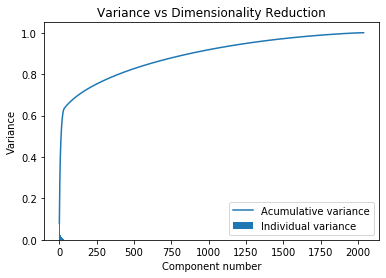

In [59]:
plt.plot(variances.Component, variances.acumulative_variance);
plt.bar(variances.Component, variances.variance);
plt.xlabel('Component number') 
plt.ylabel('Variance');
plt.legend(['Acumulative variance','Individual variance']);
plt.title('Variance vs Dimensionality Reduction');

In [60]:
variances.head()

,Component,variance,acumulative_variance
0,1.0,0.078782,0.078782
1,2.0,0.077899,0.156681
2,3.0,0.067182,0.223863
3,4.0,0.047120,0.270982
4,5.0,0.045516,0.316498


We´ve decided to keep the 95% of the variability in the original data, so we are going to reduce the dataframe to 2268 dimensions (the initial variables where 4047)

In [61]:
for i in range(len(variances)):
    if variances.acumulative_variance[i] > 0.95:
        num = i
        var = variances.acumulative_variance[i]
        break
        
print("Using", i, "variables, we can explain", round(var,2), "of the variability in the original data.")

Using 1266 variables, we can explain 0.95 of the variability in the original data.


In [73]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components = 1266)
movies_pca = pca.fit_transform(movies2)

In [74]:
movies_pca_end = pd.DataFrame(movies_pca)
movies_pca_end.head()

,0,1,2,3,4,5,6,7,8,9,...,1256,1257,1258,1259,1260,1261,1262,1263,1264,1265
0,-0.313083,-0.596921,0.128733,0.329678,-0.026006,-0.458599,-0.338517,0.264467,0.118303,-0.197870,...,0.012875,-0.094263,-0.007620,0.000602,-0.023679,-0.082121,-0.035506,-0.019697,-0.031347,0.034534
1,-0.298256,-0.573953,0.121043,0.324431,-0.009390,-0.413268,-0.327345,0.246997,0.100740,-0.165939,...,0.011507,-0.093738,-0.007792,-0.002416,-0.023527,-0.082563,-0.035874,-0.016954,-0.031493,0.034563
2,-0.145394,-0.806173,-0.139927,0.249603,0.049690,-0.458530,0.496273,0.532235,0.006408,0.204851,...,0.010875,-0.092889,-0.005380,-0.002009,-0.023497,-0.081394,-0.036433,-0.013308,-0.036993,0.035495
3,0.092604,0.305031,0.404028,0.211540,1.086561,-0.415284,-0.357267,0.261891,-0.800936,0.259004,...,0.028236,0.072781,0.001358,-0.005642,0.021938,0.021875,0.023872,0.004297,-0.012813,-0.024322
4,0.177921,0.279187,0.277387,0.244801,0.854607,-0.480492,-0.298843,0.344545,-0.627638,-0.018380,...,0.009551,0.013715,0.002324,-0.003790,0.001748,0.008443,0.008069,0.004821,-0.002090,-0.004644


#### Interpreting Principal Components

Now that we have our transformed principal components, we are going to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

In [64]:
def pc_indexes(df, pca, n):
    """
    Gives the 10 most important variables with its weights in the component n after applying pca to de dataframe df
    
    INPUT: df (dataframe), pca (transformation applied), n(principal component to analyze)
    OUTPUT: list of the top 10 variables and their weights
    """

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = df.keys())
    components.index = dimensions
    df_comp = components.iloc[n-1].to_frame()
    df_comp["Abs_value"] = df_comp.abs()
    df_comp = df_comp.sort_values(by='Abs_value', ascending = False)
    df_comp = df_comp[df_comp.columns[0]].head(10)
    return df_comp


In [65]:
# Get weights for the first principal component
pc_indexes(movies2, pca, 1)

genre_Comedy       0.5640
dec__2010         -0.5138
genre_Drama       -0.4301
dec__2000          0.3451
genre_Thriller    -0.1735
genre_Adventure    0.1201
genre_Romance      0.1042
dec__1990          0.0960
genre_Crime       -0.0947
genre_Mystery     -0.0901
Name: Dimension 1, dtype: float64

In [66]:
pc_indexes(movies2, pca, 2)

genre_Drama       -0.6528
genre_Action       0.4012
dec__2010          0.3542
genre_Adventure    0.2837
genre_Romance     -0.2706
dec__2000         -0.2507
genre_Thriller     0.1358
genre_Horror       0.1181
genre_Sci-Fi       0.0960
Year               0.0684
Name: Dimension 2, dtype: float64

In [67]:
pc_indexes(movies2, pca, 3)

genre_Comedy     -0.5428
dec__2010        -0.4685
dec__2000         0.4240
genre_Action      0.2727
genre_Thriller    0.2674
genre_Romance    -0.2494
genre_Crime       0.2327
genre_Horror      0.1100
genre_Mystery     0.1093
genre_Drama      -0.0630
Name: Dimension 3, dtype: float64

In [68]:
pc_indexes(movies2, pca, 4)

dec__2000       -0.6123
dec__1990        0.6008
dec__2010       -0.3432
genre_Crime      0.2249
Year            -0.2009
dec__1980        0.1567
genre_Romance   -0.0750
dec__1970        0.0678
genre_Horror    -0.0545
dec__1960        0.0471
Name: Dimension 4, dtype: float64

We can see that the first 4 principal components are based on the genre and when it was filmed (different decades or year)

#### Merging dataframes

In [69]:
movies_pca_end

,0,1,2,3,4,5,6,7,8,9,...,1256,1257,1258,1259,1260,1261,1262,1263,1264,1265
0,-0.313083,-0.596921,0.128733,0.329678,-0.026006,-0.458599,-0.338517,0.264467,0.118303,-0.197870,...,-0.060912,0.028369,-0.005244,-0.073621,0.012917,0.029893,0.028767,-0.087477,0.019862,0.052218
1,-0.298256,-0.573953,0.121043,0.324431,-0.009390,-0.413268,-0.327345,0.246997,0.100740,-0.165939,...,-0.060661,0.027162,-0.005903,-0.074775,0.013521,0.030665,0.028647,-0.087465,0.020748,0.050294
2,-0.145394,-0.806173,-0.139927,0.249603,0.049690,-0.458530,0.496273,0.532235,0.006408,0.204851,...,-0.057606,0.027307,-0.010158,-0.073819,0.012280,0.031713,0.028077,-0.084702,0.019710,0.049007
3,0.092604,0.305031,0.404028,0.211540,1.086561,-0.415284,-0.357267,0.261891,-0.800936,0.259004,...,-0.002563,0.011025,0.001822,-0.016977,0.007887,0.033359,-0.022367,0.014773,-0.053429,0.022358
4,0.177921,0.279187,0.277387,0.244801,0.854607,-0.480492,-0.298843,0.344545,-0.627638,-0.018380,...,0.001713,0.004361,-0.003768,-0.000465,0.001106,0.014828,-0.000520,0.000808,-0.009282,0.005011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11061,0.779341,-0.053386,-0.666477,0.031961,0.255477,0.048098,0.570268,0.317863,-0.016379,0.154973,...,-0.009341,-0.003148,-0.001277,0.003420,-0.009966,-0.000939,0.005210,-0.000306,-0.004765,0.010536
11062,-0.740223,0.008059,-0.423086,-0.273971,-0.088684,-0.305192,-0.349651,-0.191526,-0.117616,0.184015,...,-0.004628,0.015197,0.014687,0.001122,-0.030242,-0.020445,0.004611,0.021908,-0.029441,0.003700
11063,0.266562,0.297840,-1.137491,-0.311654,0.212950,0.209763,0.619584,0.195177,-0.072759,0.221199,...,-0.041269,-0.026256,0.008887,0.023886,-0.025701,-0.007589,-0.016731,-0.000159,-0.004366,-0.010946
11064,0.647404,0.615354,-0.150650,0.150856,-0.287874,0.149356,0.142649,0.122011,-0.091860,-0.615983,...,0.025679,-0.049980,0.012339,-0.027596,0.020097,0.031291,-0.010174,-0.007627,-0.019651,-0.036753


In [70]:
movies1

,quality
0,5
1,5
2,5
3,10
4,5
...,...
11061,5
11062,5
11063,0
11064,0


In [75]:
df_movies = pd.merge(movies1, movies_pca_end, left_index=True, right_index=True)

In [76]:
df_movies.head()

,quality,0,1,2,3,4,5,6,7,8,...,1256,1257,1258,1259,1260,1261,1262,1263,1264,1265
0,5,-0.313083,-0.596921,0.128733,0.329678,-0.026006,-0.458599,-0.338517,0.264467,0.118303,...,0.012875,-0.094263,-0.007620,0.000602,-0.023679,-0.082121,-0.035506,-0.019697,-0.031347,0.034534
1,5,-0.298256,-0.573953,0.121043,0.324431,-0.009390,-0.413268,-0.327345,0.246997,0.100740,...,0.011507,-0.093738,-0.007792,-0.002416,-0.023527,-0.082563,-0.035874,-0.016954,-0.031493,0.034563
2,5,-0.145394,-0.806173,-0.139927,0.249603,0.049690,-0.458530,0.496273,0.532235,0.006408,...,0.010875,-0.092889,-0.005380,-0.002009,-0.023497,-0.081394,-0.036433,-0.013308,-0.036993,0.035495
3,10,0.092604,0.305031,0.404028,0.211540,1.086561,-0.415284,-0.357267,0.261891,-0.800936,...,0.028236,0.072781,0.001358,-0.005642,0.021938,0.021875,0.023872,0.004297,-0.012813,-0.024322
4,5,0.177921,0.279187,0.277387,0.244801,0.854607,-0.480492,-0.298843,0.344545,-0.627638,...,0.009551,0.013715,0.002324,-0.003790,0.001748,0.008443,0.008069,0.004821,-0.002090,-0.004644


### <a class="anchor" id="Alg_Selection"> 3.b.- Algorithm Selection
We´re going to test a few regression algorithms with all the features and the default parameters to see which one works better and we will check the naive predictor
    
**Naive Predictor Performace**

22.9% of movies are of category 0, 70% are of category 5 and 7.1% are of category 10. In this top voted movies, the quality is higher than when we got all movies.
    
The Naive Predictor would be a silly predictor that predicts all movies belong to category 5 and an accuracy of 0.70. The score would be of a silly predictor with no intelligence. We calculate it as a reference for our scores
    

    
**Testing algorithms**
    


In [78]:
X = df_movies.drop("quality", axis=1).copy()
y = df_movies["quality"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8852, 1266), (8852,), (2214, 1266), (2214,))

In [74]:
#function to test the algorithm
def test_model(alg):
    train_score = 0
    test_score = 0
    clf = alg
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True,zero_division= 0  )
    df_rep = pd.DataFrame(report)
    
    
    accuracy = df_rep.iloc[0,3]
    f1_macro = df_rep.iloc[2,4]
    f1_weight = df_rep.iloc[2,5]
    
    return accuracy, f1_macro, f1_weight

In [75]:
model_comparison_df = pd.DataFrame(columns=['Algorithm','Accuracy','F1_macro', 'F1_weight'])       

In [76]:
#Test Linear Regression, create df of scores and its score
model = test_model(LogisticRegression())
model_comparison_df = model_comparison_df.append({'Algorithm' : 'LogisticRegression()', 'Accuracy' : model[0], 'F1_macro' : model[1], 'F1_weight' : model[2]} , ignore_index=True)

C:\Users\cance\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [78]:
#Test SVC, create add score to df
model = test_model(SVC())
model_comparison_df = model_comparison_df.append({'Algorithm' : 'SVC', 'Accuracy' : model[0], 'F1_macro' : model[1], 'F1_weight' : model[2]} , ignore_index=True)

In [79]:
#Test KNeighborsClassifier, create add score to df
model =test_model(KNeighborsClassifier(n_neighbors = 3))
model_comparison_df = model_comparison_df.append({'Algorithm' : 'KNeighborsClassifier', 'Accuracy' : model[0], 'F1_macro' : model[1], 'F1_weight' : model[2]} , ignore_index=True)

In [81]:
#Test GaussianNB(), create add score to df
model =test_model(GaussianNB())
model_comparison_df = model_comparison_df.append({'Algorithm' : 'GaussianNB', 'Accuracy' : model[0], 'F1_macro' : model[1], 'F1_weight' : model[2]} , ignore_index=True)

In [82]:
#Test Perceptron(), create add score to df
model =test_model(Perceptron())
model_comparison_df = model_comparison_df.append({'Algorithm' : 'Perceptron', 'Accuracy' : model[0], 'F1_macro' : model[1], 'F1_weight' : model[2]} , ignore_index=True)

In [83]:
#Test SGDClassifier(), create add score to df
model =test_model(SGDClassifier())
model_comparison_df = model_comparison_df.append({'Algorithm' : 'SGDClassifier', 'Accuracy' : model[0], 'F1_macro' : model[1], 'F1_weight' : model[2]} , ignore_index=True)

In [84]:
#Test RandomForestClassifier(n_estimators=100), create add score to df
model =test_model(RandomForestClassifier(n_estimators=100))
model_comparison_df = model_comparison_df.append({'Algorithm' : 'RandomForestClassifier', 'Accuracy' : model[0], 'F1_macro' : model[1], 'F1_weight' : model[2]} , ignore_index=True)

In [85]:
#Test AdaBoostClassifier(n_estimators=100), create add score to df
model =test_model(AdaBoostClassifier(n_estimators=100))
model_comparison_df = model_comparison_df.append({'Algorithm' : 'AdaBoostClassifier', 'Accuracy' : model[0], 'F1_macro' : model[1], 'F1_weight' : model[2]} , ignore_index=True)

In [86]:
#Test LinearSVC(), create add score to df
model =test_model(LinearSVC())
model_comparison_df = model_comparison_df.append({'Algorithm' : 'LinearSVC', 'Accuracy' : model[0], 'F1_macro' : model[1], 'F1_weight' : model[2]} , ignore_index=True)

In [87]:
model_comparison_df[['Algorithm','Accuracy','F1_weight']].sort_values(by ='F1_weight', ascending = False)

,Algorithm,Accuracy,F1_weight
0,LogisticRegression(),0.774616,0.756829
8,LinearSVC,0.747516,0.726942
1,SVC,0.764228,0.726230
7,AdaBoostClassifier,0.720416,0.720859
5,SGDClassifier,0.744806,0.718499
6,RandomForestClassifier,0.740741,0.681679
2,KNeighborsClassifier,0.689250,0.673901
4,Perceptron,0.655375,0.658763
3,GaussianNB,0.461156,0.510038


We can see that accuracy with most of the models is higher than the naive predictor (0.70), and the best algorithm in Accuracy and F1 score is the Logistic Regression.

Definetely, predicting labels for this IMDB project has much better results than predicting directly the average score but the results are really poor. Having a naive predictor with 70% accuracy and getting only 77% of accuracy is not a good result.

Next step should be tuning with hyperparameters but, although we could increase a bit the results, they are not going to be good, so we stop here.